<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


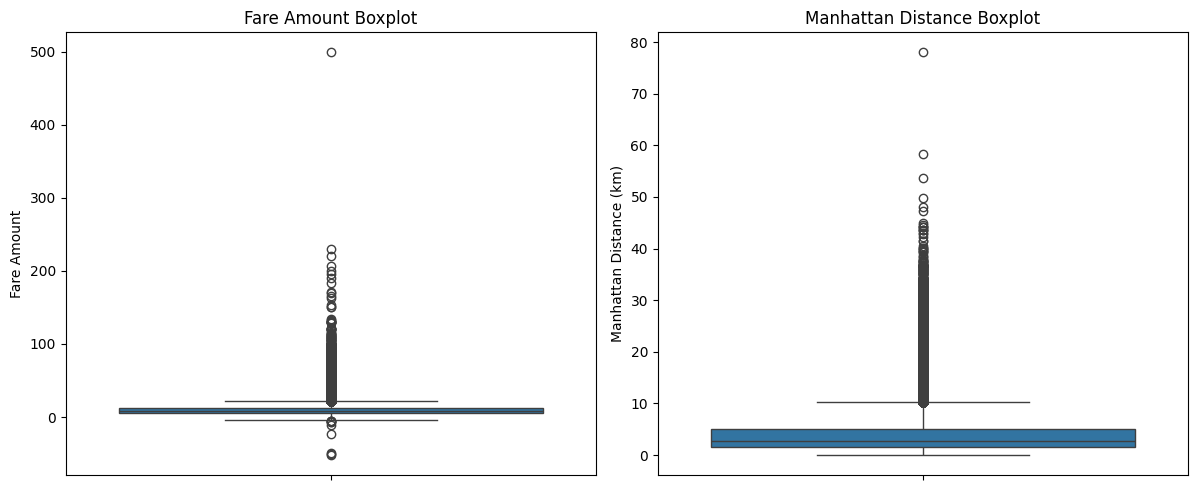

Fare Amount Bounds: (-3.75, 22.25), Outliers Detected: 16709
Manhattan Distance Bounds: (-3.40938650000151, 10.794937500000408), Outliers Detected: 13521
Passenger Count Bounds: (-0.5, 3.5), Outliers Detected: 22079


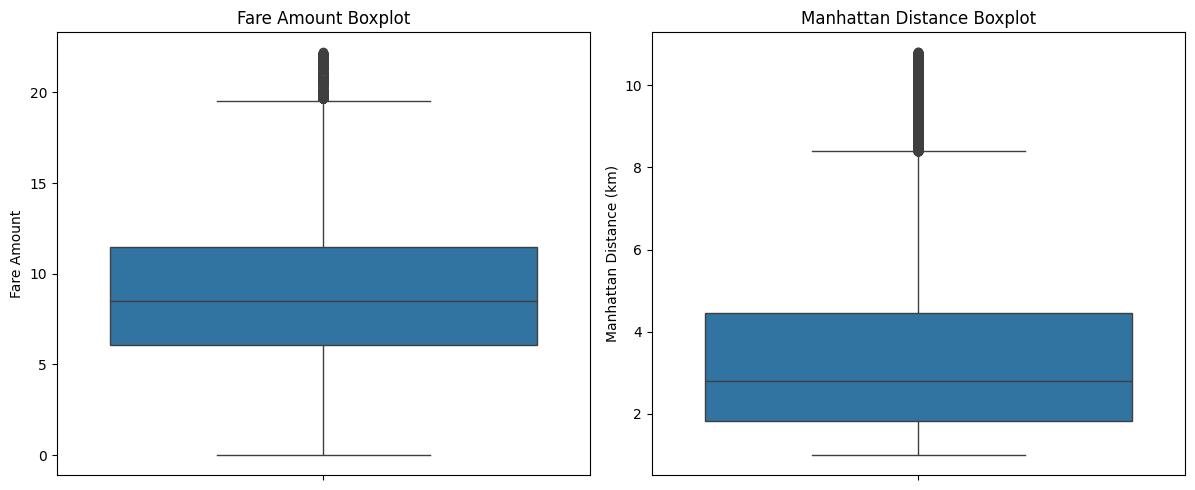

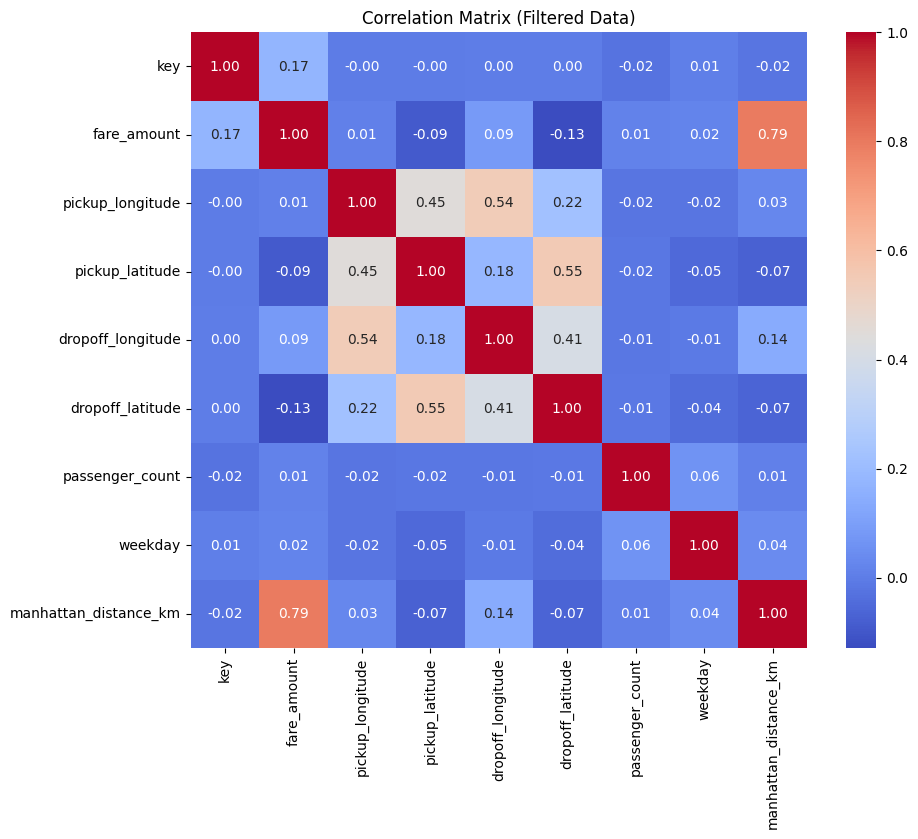

C:\Users\AYUSHI CHOUGULE\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\AYUSHI CHOUGULE\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Linear Regression RMSE: 2.39, R^2: 0.63
Ridge Regression RMSE: 2.39, R^2: 0.63
Lasso Regression RMSE: 2.39, R^2: 0.63
               Model      RMSE       R^2
0  Linear Regression  2.390065  0.625717
1   Ridge Regression  2.390065  0.625717
2   Lasso Regression  2.390176  0.625682


C:\Users\AYUSHI CHOUGULE\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score


uber = pd.read_csv("uber.csv")

uber.shape

uber.info()

uber.sample(5)

 # 1. Pre-process the dataset 
# Dropping Unnecessary Columns-Columns "Unnamed: 0" and "pickup_datetime" seems unnecessary.
uber.drop(columns=["Unnamed: 0", "pickup_datetime"], inplace = True)

uber.isnull().sum() * 100 / len(uber)

uber.dropna(axis=0, inplace=True)

uber.isnull().sum()

uber.shape

# Extracting Weekday From Key Column
uber["key"] = pd.to_datetime(uber["key"])
uber["weekday"] = uber["key"].dt.weekday

# Computing Manhattan Distance in km from the coordinates
lat_to_km = 111  # km per degree of latitude
long_to_km = 85  # km per degree of longitude

uber['manhattan_distance_km'] = (uber['pickup_latitude'] - uber['dropoff_latitude']).abs() * lat_to_km + \
                              (uber['pickup_longitude'] - uber['dropoff_longitude']).abs() * long_to_km

uber.sample(5)

# 2. Identify outliers
uber.describe()
#Observation
#- Some max and min values for a coordinate are too extreme
#- Longitude Values should range between 40.5 to 41.0
#- Latitude values should range between -74.5 to -73.5
#- Fare amount cannot be negative
#- Uber ride cannot have very high passenger count or 0 passenger count
#- Distance in 1000s of km is too exterme

nyc_latitude_range = (40.5, 41.0)
nyc_longitude_range = (-74.5, -73.5)

# Filter the DataFrame to include only rows with coordinates within NYC-specific ranges
uber_confined = uber[(uber['pickup_latitude'].between(nyc_latitude_range[0], nyc_latitude_range[1])) &
                (uber['pickup_longitude'].between(nyc_longitude_range[0], nyc_longitude_range[1])) &
                (uber['dropoff_latitude'].between(nyc_latitude_range[0], nyc_latitude_range[1])) &
                (uber['dropoff_longitude'].between(nyc_longitude_range[0], nyc_longitude_range[1]))]


uber_confined.shape

uber_confined.describe()

# Function to detect outliers using IQR method with logical conditions
def detect_outliers_iqr_with_conditions(df, column_name, logical_conditions):
    # Apply logical conditions to filter the DataFrame
    filtered_df = df.query(logical_conditions)

    Q1 = filtered_df[column_name].quantile(0.25)
    Q3 = filtered_df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = filtered_df[(filtered_df[column_name] < lower_bound) | (filtered_df[column_name] > upper_bound)]

    return lower_bound, upper_bound, outliers

def uber_boxplot(df):
  # Plotting boxplots for visual inspection
  plt.figure(figsize=(18, 5))

  # Boxplot for fare_amount
  plt.subplot(1, 3, 1)
  sns.boxplot(data=df, y='fare_amount')
  plt.title('Fare Amount Boxplot')
  plt.ylabel('Fare Amount')

  # Boxplot for manhattan_distance_km
  plt.subplot(1, 3, 2)
  sns.boxplot(data=df, y='manhattan_distance_km')
  plt.title('Manhattan Distance Boxplot')
  plt.ylabel('Manhattan Distance (km)')

  plt.tight_layout()
  plt.show()

uber_boxplot(uber_confined)

# Detect outliers for fare_amount
fare_lower, fare_upper, fare_outliers = detect_outliers_iqr_with_conditions(
    uber_confined, 'fare_amount', 'fare_amount > 0'
)
print(f"Fare Amount Bounds: ({fare_lower}, {fare_upper}), Outliers Detected: {fare_outliers.shape[0]}")

# Detect outliers for manhattan_distance_km
distance_lower, distance_upper, distance_outliers = detect_outliers_iqr_with_conditions(
    uber_confined, 'manhattan_distance_km', 'manhattan_distance_km > 1'
)
print(f"Manhattan Distance Bounds: ({distance_lower}, {distance_upper}), Outliers Detected: {distance_outliers.shape[0]}")

# Detect outliers for passenger_count
passenger_lower, passenger_upper, passenger_outliers = detect_outliers_iqr_with_conditions(
    uber_confined, 'passenger_count', '(passenger_count > 0) & (passenger_count <= 6)'
)
print(f"Passenger Count Bounds: ({passenger_lower}, {passenger_upper}), Outliers Detected: {passenger_outliers.shape[0]}")

uber_cleaned = uber_confined[((uber_confined['fare_amount'] > 0) & (uber_confined['fare_amount'] < fare_upper)) &
                            ((uber_confined['manhattan_distance_km'] < distance_upper) & (uber_confined['manhattan_distance_km'] > 1)) &
                             ((uber_confined['passenger_count'] > 0) & (uber_confined['passenger_count'] < passenger_upper))]
uber_cleaned.shape

uber_cleaned.describe()

uber_boxplot(uber_cleaned)

# Calculate the correlation matrix for the filtered DataFrame
correlation_matrix_filtered = uber_cleaned.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_filtered, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Correlation Matrix (Filtered Data)')
plt.show()

# 4. Implement linear regression and ridge, Lasso regression models
X = uber_cleaned[['manhattan_distance_km']]
y = uber_cleaned['fare_amount']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
y_pred_linear = linear_model.predict(X_test)

# Evaluate the model
linear_rmse = mean_squared_error(y_test, y_pred_linear, squared=False)
linear_r2 = r2_score(y_test, y_pred_linear)

print(f"Linear Regression RMSE: {linear_rmse:.2f}, R^2: {linear_r2:.2f}")

# Create a Ridge Regression model with a regularization parameter (alpha)
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate the model
ridge_rmse = mean_squared_error(y_test, y_pred_ridge, squared=False)
ridge_r2 = r2_score(y_test, y_pred_ridge)

print(f"Ridge Regression RMSE: {ridge_rmse:.2f}, R^2: {ridge_r2:.2f}")

# Create a Lasso Regression model with a regularization parameter (alpha)
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

# Make predictions
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate the model
lasso_rmse = mean_squared_error(y_test, y_pred_lasso, squared=False)
lasso_r2 = r2_score(y_test, y_pred_lasso)

print(f"Lasso Regression RMSE: {lasso_rmse:.2f}, R^2: {lasso_r2:.2f}")

# Summary of the results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'RMSE': [linear_rmse, ridge_rmse, lasso_rmse],
    'R^2': [linear_r2, ridge_r2, lasso_r2]
})

print(results)


